In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

import matplotlib.pyplot as plt 
import matplotlib 
matplotlib.rcParams.update({'font.size': 14})
# 'text.usetex': True, 'font.family': 'Helvetica'
%matplotlib inline

from utils.models import MLP
from utils.trainer import train_MLP
from utils.data import create_xor_dataset
from utils.plotting import plot_var

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


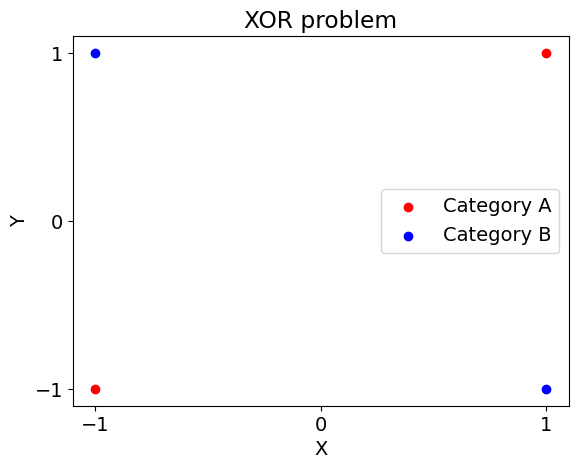

In [46]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

plt.scatter(x1[y == -1.], x2[y == -1.], c = 'r', label = 'Category A')
plt.scatter(x1[y == 1.], x2[y == 1.], c = 'b', label = 'Category B')
plt.xlabel('X')
plt.ylabel('Y')
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.legend()
plt.title('XOR problem')

X = torch.tensor([x1, x2]).T
y = torch.tensor(y).unsqueeze(1)

In [58]:
n_runs = 20
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (0, 1)

lr = 2e-3  # Learning rate
# Initialization scale
w1_inits = [0.001,0.01,0.1,0.5]
w2_init = 1/dim_hidden

models = []
losses = np.zeros((len(w1_inits), n_runs, n_epochs))

# Training
for w_i, w1_init in enumerate(w1_inits):
    for r_i in range(n_runs):
        # Model instantiation
        dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
    
        loss_per_run, _ = train_MLP(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
        losses[w_i, r_i, :] = loss_per_run

    models.append(dlnn_model)

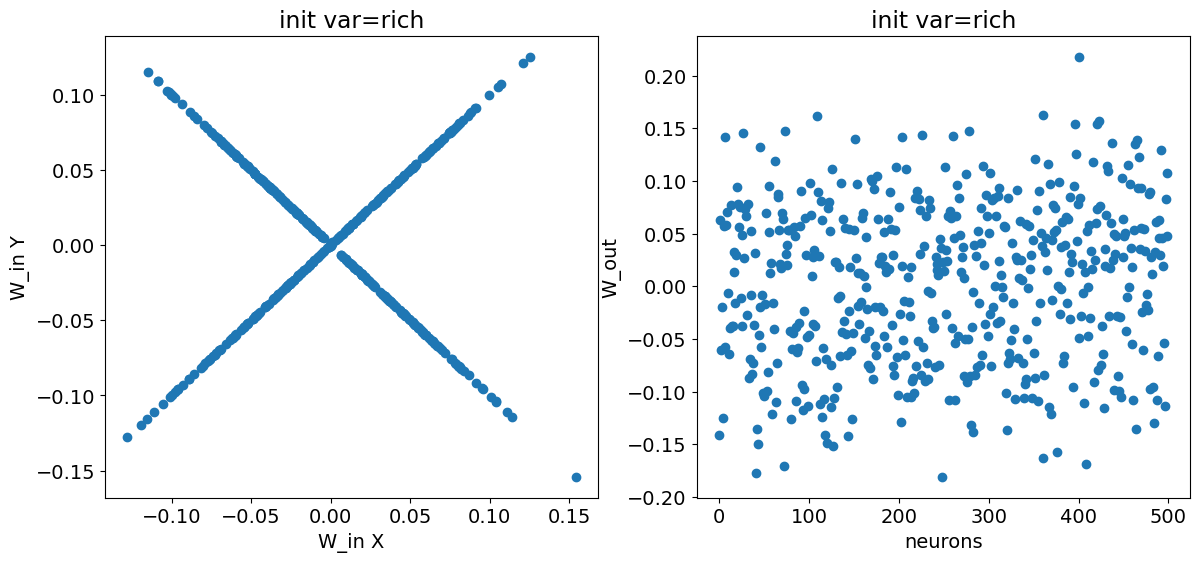

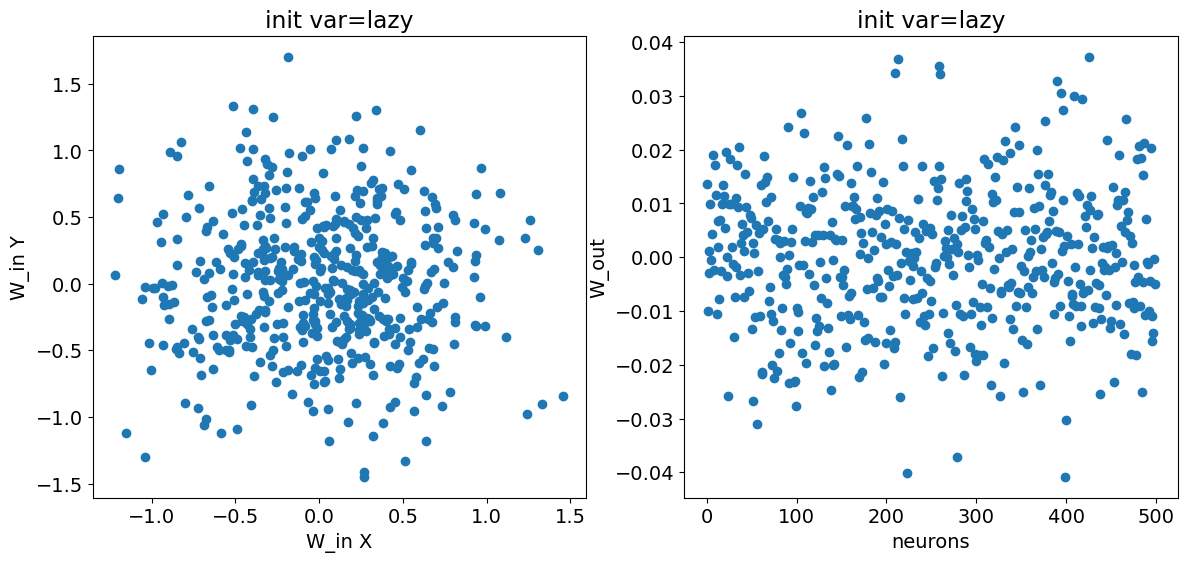

In [59]:
rich_lazy_models = [models[0], models[-1]]
model_titles = ['rich', 'lazy']

for w_i, weight in enumerate(model_titles):
    model = rich_lazy_models[w_i]
    
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(14, 6)

    for p_i, (name, param) in enumerate(model.named_parameters()):
        axis = axes[p_i]

        if name == 'in_hid.weight':
            in_hid = param.detach().numpy()
            axis.scatter(in_hid[:, 0], in_hid[:, 1])

            axis.set_xlabel('W_in X')
            axis.set_ylabel('W_in Y')
            # axis.set_xlim(-0.05, 0.05)
            # axis.set_ylim(-0.05, 0.05)

            axis.set_title(f'init var={weight}')

        elif name == 'hid_out.weight':
            hid_out = param.detach().numpy()
            axis.scatter(np.arange(hid_out.shape[1]), hid_out[0])

            axis.set_xlabel('neurons')
            axis.set_ylabel('W_out')
            # axis.set_ylim(-0.05, 0.05)

            axis.set_title(f'init var={weight}')

## Repeated training of one contingency

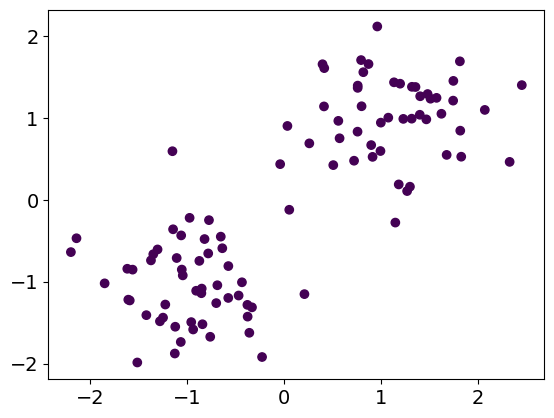

In [60]:
bias_models = []
for model in models:
    bias_models.append(copy.deepcopy(model))

bias_x1 = np.array ([1., -1.], dtype = np.float32)
bias_x2 = np.array ([1., -1.], dtype = np.float32)
bias_y  = np.array ([-1., -1.],dtype = np.float32)
bias_X_train, bias_y_train = create_xor_dataset(bias_x1, bias_x2, bias_y, n_repeats=50, noise_lev=0.5)

plt.scatter(bias_X_train[:, 0], bias_X_train[:, 1], c = bias_y_train)

In [61]:
n_runs = 1
n_epochs = 10000  # Number of epochs

lr = 2e-3  # Learning rate

bias_losses = np.zeros((2, n_runs, n_epochs))
# Training
for m_i, bias_model in enumerate([bias_models[0], bias_models[-1]]):
    for r_i in range(n_runs):
        bias_loss_per_run, _ = train_MLP(bias_model, bias_X_train, bias_y_train, n_epochs=n_epochs, lr=lr)
        bias_losses[m_i, r_i, :] = bias_loss_per_run

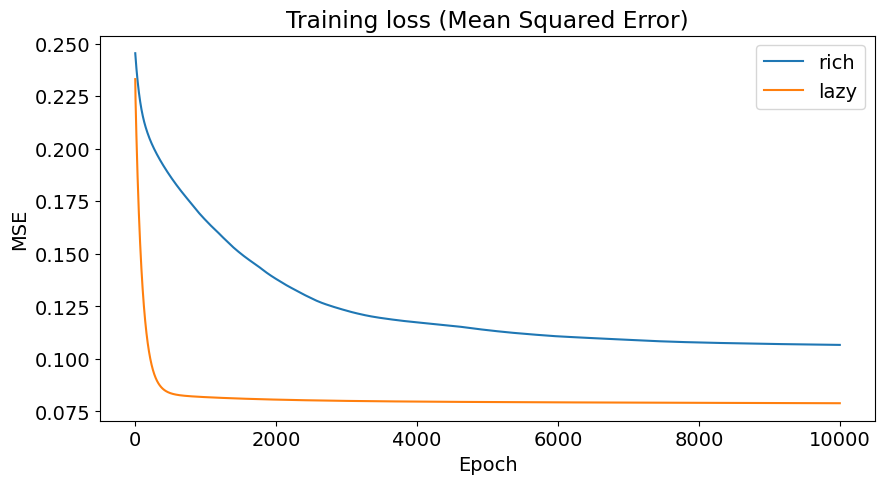

In [62]:
# Plotting losses after repeated training of one contingency
plot_var(bias_losses, parameters=['rich', 'lazy'])

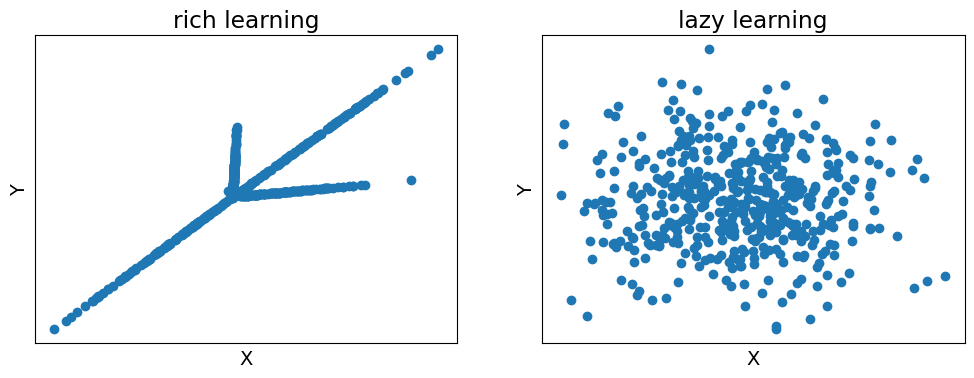

In [63]:
bias_rich_lazy_models = [bias_models[0], bias_models[-1]]
model_titles = ['rich', 'lazy']

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
for a_i, axis in enumerate(axes):
    model = bias_rich_lazy_models[a_i]
    for name, param in model.named_parameters():
        if name == 'in_hid.weight':
            in_hid = param.detach().numpy()
            axis.scatter(in_hid[:, 0], in_hid[:, 1])
            axis.set_xticks([])
            axis.set_yticks([])
            axis.set_xlabel('X')
            axis.set_ylabel('Y')
            axis.set_title(f'{model_titles[a_i]} learning')

## Replaying the other contingency

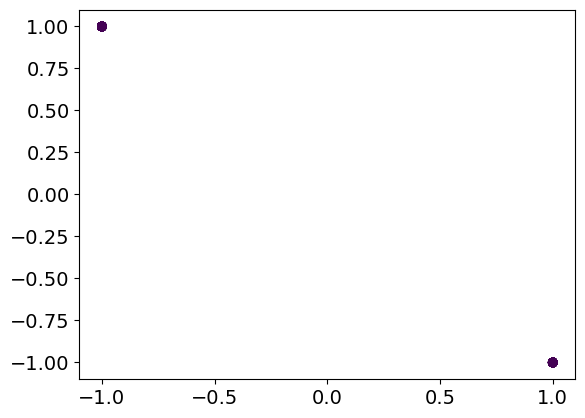

In [103]:
replay_bias_models = []
for bias_model in bias_models:
    replay_bias_models.append(copy.deepcopy(bias_model))

replay_bias_x1 = np.array ([-1., 1.], dtype = np.float32)
replay_bias_x2 = np.array ([1., -1.], dtype = np.float32)
replay_bias_y  = np.array ([1., 1.],dtype = np.float32)

# replay_bias_X = torch.tensor([replay_bias_x1, replay_bias_x2]).T
# replay_bias_y = torch.tensor(replay_bias_y).unsqueeze(1)
# plt.scatter(replay_bias_X[:, 0], replay_bias_X[:, 1])

replay_bias_X, replay_bias_y = create_xor_dataset(replay_bias_x1, replay_bias_x2, replay_bias_y, n_repeats=50, noise_lev=0)
plt.scatter(replay_bias_X[:, 0], replay_bias_X[:, 1], c = replay_bias_y)

In [104]:
n_runs = 1
n_epochs = 10000  # Number of epochs

lr = 2e-3  # Learning rate

replay_bias_losses = np.zeros((2, n_runs, n_epochs))
# Training
for m_i, replay_bias_model in enumerate([replay_bias_models[0], replay_bias_models[-1]]):
    for r_i in range(n_runs):
        replay_bias_loss_per_run, _ = train_MLP(replay_bias_model, replay_bias_X, replay_bias_y, n_epochs=n_epochs, lr=lr)
        replay_bias_losses[m_i, r_i, :] = replay_bias_loss_per_run

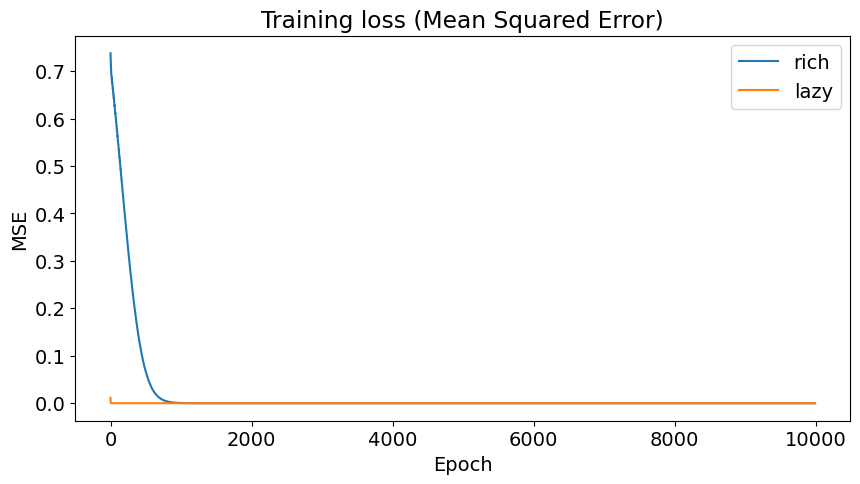

In [105]:
# Plotting losses after replaying the other contingency
plot_var(replay_bias_losses[:, :, 10:], parameters=['rich', 'lazy'])

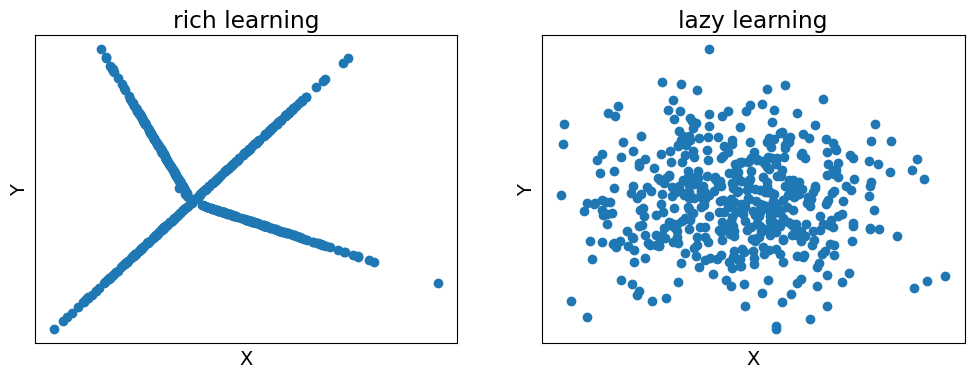

In [106]:
replay_bias_rich_lazy_models = [replay_bias_models[0], replay_bias_models[-1]]
model_titles = ['rich', 'lazy']

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
for a_i, axis in enumerate(axes):
    model = replay_bias_rich_lazy_models[a_i]
    for name, param in model.named_parameters():
        if name == 'in_hid.weight':
            in_hid = param.detach().numpy()
            axis.scatter(in_hid[:, 0], in_hid[:, 1])
            axis.set_xticks([])
            axis.set_yticks([])
            axis.set_xlabel('X')
            axis.set_ylabel('Y')
            axis.set_title(f'{model_titles[a_i]} learning')